# Deep learning Spring 2025

- **Name:** `Ali Zahedzadeh`
- **Student ID:** `4021305965003`



---



- **Name:** `Peyman Naseri`
- **Student ID:** `4011305965014`



# 1

> **Q1. How does unidirectional attention work in GPT?**
>
> * GPT uses *masked self-attention*: each token can only “look left” (attend to positions ≤ t).
> * The mask is an upper-triangular matrix added before soft-max, forcing causal ordering.
> * This lets the model predict the next token p(xₜ | x₍₀…t-1₎) while still capturing long-range dependencies through multiple layers of attention.
> * Because attention flows in one direction, GPT is naturally suited for text generation and auto-regressive fine-tuning.



> **Q2. Key architectural differences between BERT and GPT**
>
> | Aspect                 | GPT (Radford et al./Brown et al.)                                     | BERT (Devlin et al.)                                                  |
> | ---------------------- | --------------------------------------------------------------------- | --------------------------------------------------------------------- |
> | Attention              | *Unidirectional* (causal mask)                                        | *Bidirectional* (full self-attention)                                 |
> | Pre-training objective | Language modeling (next-token prediction)                             | Masked-Language Modeling + Next-Sentence Prediction                   |
> | Positional encoding    | Learned (absolute)                                                    | Learned (absolute)                                                    |
> | Tokenization           | Byte-Pair Encoding (BPE)                                              | WordPiece                                                             |
> | Fine-tuning style      | Add task-specific head; occasionally reformulate task as generation   | Add classification/regression head on **\[CLS]** token; encoder-style |
> | Strengths              | Text generation, conditional generation, few-shot in-context learning | Discriminative tasks (NLI, QA span extraction)                        |

Summary:
GPT is like a writer; it uses the past to build the future.
BERT is like an editor; it reads the entire sentence at once to analyze it.



> **Q3. Pre-training & fine-tuning process for GPT**
>
> 1. **Pre-training**
>
>    * Collect massive unlabeled corpus (e.g., WebText, CommonCrawl).
>    * Tokenize with BPE; train transformer decoder using causal LM loss.
>    * Learn general-purpose language representations.
> 2. **Fine-tuning**
>
>    * Append a small task-specific head (e.g., linear layer over hidden state of last token).
>    * Option A – *Full fine-tune*: unfreeze all layers; train with cross-entropy restricted to target tokens (e.g., “positive”/“negative”).
>    * Option B – *Partial/LoRA*: freeze backbone; inject low-rank adapters or train only top layers to reduce compute & over-fitting.
>    * Use small learning-rate, weight decay, early stopping; sometimes truncate long sequences or add prompt engineering to match task format.


# 2

In [1]:
# --------------------------- setup ---------------------------
# !pip install -q datasets transformers torch tqdm pandas matplotlib seaborn


In [2]:
!pip install --upgrade datasets fsspec

  Using cached fsspec-2025.5.0-py3-none-any.whl.metadata (11 kB)


In [3]:

from datasets import load_dataset
from transformers import GPT2Tokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
sns.set_theme(style="whitegrid", font_scale=1.1)


In [4]:
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)

### 2.2.a Dataset Exploration


In [5]:
# load IMDb
imdb = load_dataset("imdb", cache_dir="/home/p_naseri/hf_cache")
train_raw, test_raw = imdb["train"], imdb["test"]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
# ----------------- quick EDA: class balance -----------------
def show_class_distribution(ds, name):
    counts = ds["label"].count(0), ds["label"].count(1)
    print(f"{name} set  | negative: {counts[0]}  positive: {counts[1]}")

show_class_distribution(train_raw, "train")
show_class_distribution(test_raw,  "test")


train set  | negative: 12500  positive: 12500
test set  | negative: 12500  positive: 12500


In [7]:
train_raw['text'][0], train_raw['label'][1]

('I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

In [8]:
# text length statistics
lens = [len(txt) for txt in train_raw["text"]]
pd.Series(lens).describe(percentiles=[.25,.5,.75,.9,.95])


,0
count,25000.00000
mean,1325.06964
std,1003.13367
min,52.00000
25%,702.00000
50%,979.00000
75%,1614.00000
90%,2617.00000
95%,3432.05000
max,13704.00000


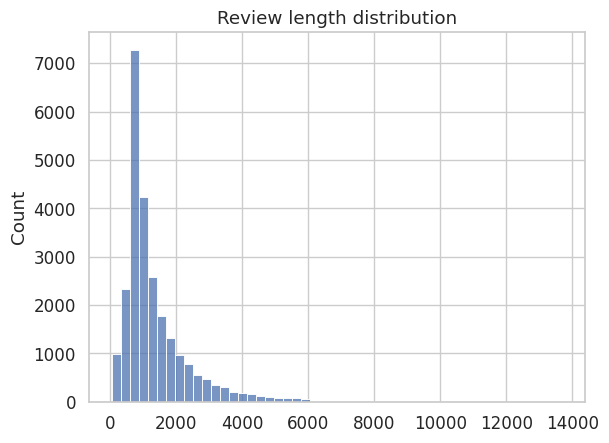

In [9]:
# histogram
sns.histplot(lens, bins=50); plt.title("Review length distribution");



The IMDb dataset is perfectly balanced: **12 500 positive / 12 500 negative** reviews in both the train and test splits.

| Statistic | Characters per review |
|-----------|-----------------------|
| Mean      | 1 325.1 |
| Median    | 979 |
| Min       | 52 |
| 25-th Pctl| 702 |
| 75-th Pctl| 1 614 |
| 90-th Pctl| 2 617 |
| 95-th Pctl| 3 432 |
| Max       | 13 704 |

As the histogram in Fig.&nbsp;1 shows, most reviews are shorter than **2 000 chars** with a long right-tail.  
To speed up training, we truncate each text to **≤ 500 characters**, preserving 90 %+ of samples while keeping sequence length manageable for GPT-2.


### 2-2.b stringify samples

In [10]:
def format_example(example):
    text = example["text"][:500]   # truncate to 500 chars
    # text = example["text"]
    label = "positive" if example["label"]==1 else "negative"
    return {"formatted": f"Review: {text}\nSentiment: {label}"}

train_fmt = train_raw.map(format_example)
test_fmt  = test_raw.map(format_example)



Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

### 2-2.c tokenization

In [11]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize(batch):
    return tokenizer(batch["formatted"], padding="max_length", truncation=True, max_length=512)

train_tok = train_fmt.shuffle(seed=SEED).select(range(5000)).map(tokenize, batched=True, remove_columns=train_fmt.column_names)
test_tok  = test_fmt.shuffle(seed=SEED).select(range(1000)).map(tokenize, batched=True, remove_columns=test_fmt.column_names)

# train_tok = train_fmt.shuffle(seed=SEED).map(tokenize, batched=True, remove_columns=train_fmt.column_names)
# test_tok  = test_fmt.shuffle(seed=SEED).map(tokenize, batched=True, remove_columns=test_fmt.column_names)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## 2-2.d dataloader helper

In [12]:
def to_torch(ds):
    ds.set_format(type="torch", columns=["input_ids", "attention_mask"])
    return ds

train_ds = to_torch(train_tok)
test_ds  = to_torch(test_tok)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_ds,  batch_size=8)

# sanity check
batch = next(iter(train_loader))
print(batch["input_ids"].shape, batch["attention_mask"].shape)

torch.Size([8, 512]) torch.Size([8, 512])


In [13]:
batch

{'input_ids': tensor([[14832,    25,  2893,  ..., 50256, 50256, 50256],
         [14832,    25,  1623,  ..., 50256, 50256, 50256],
         [14832,    25,  7945,  ..., 50256, 50256, 50256],
         ...,
         [14832,    25,   770,  ..., 50256, 50256, 50256],
         [14832,    25,   632,  ..., 50256, 50256, 50256],
         [14832,    25,   314,  ..., 50256, 50256, 50256]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

# 3

## 3.1 model setup

In [14]:
from transformers import GPT2LMHeadModel, get_linear_schedule_with_warmup
from torch.optim import AdamW

import itertools

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))  # keep embedding-LM head tied

# ---- freeze bottom 10 layers, train only last 2 Transformer blocks ----
for name, param in model.named_parameters():
    # GPT-2 small has 12 decoder blocks: transformer.h.0 … transformer.h.11
    if not name.startswith(("transformer.h.10", "transformer.h.11", "lm_head")):
        param.requires_grad = False

model = model.to(DEVICE)
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Trainable parameters: 14,175,744


## 3.2 loss wrapper

In [15]:
IGNORE_INDEX = -100  # tokens with this label will be ignored by CrossEntropyLoss
criterion = torch.nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

def add_labels(batch):
    """
    For LM fine-tuning we feed the *entire* prompt but only compute loss
    on the sentiment token ('positive' / 'negative').
    We do this by masking everything except the last non-pad token.
    """
    input_ids = batch["input_ids"]
    labels = input_ids.clone()

    # find index of last non-padding token in each sequence
    eos_mask = input_ids.ne(tokenizer.pad_token_id)
    last_token_indices = eos_mask.sum(dim=1) - 1  # [batch_size]

    # mask out all positions except last_token_indices
    labels[:] = IGNORE_INDEX
    for i, idx in enumerate(last_token_indices):
        labels[i, idx] = input_ids[i, idx]

    batch["labels"] = labels
    return batch

train_ds_wlbl = train_ds.map(add_labels, batched=True)
test_ds_wlbl  = test_ds.map(add_labels, batched=True)


train_loader = torch.utils.data.DataLoader(train_ds_wlbl, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(test_ds_wlbl,  batch_size=8)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

## 3.3 training loop

In [16]:
EPOCHS = 2
LR = 5e-5
TOTAL_STEPS = EPOCHS * len(train_loader)

optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0.1 * TOTAL_STEPS, num_training_steps=TOTAL_STEPS
)

def train_one_epoch(epoch):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
    return total_loss / len(train_loader)

for epoch in range(1, EPOCHS + 1):
    avg_loss = train_one_epoch(epoch)
    print(f"Epoch {epoch} | mean training loss: {avg_loss:.4f}")


Epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1 | mean training loss: 1.1661


Epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2 | mean training loss: 0.4100


# 4

## 4.1 evaluation

In [27]:
# Constants for the two sentiment tokens in GPT-2 BPE
POS_ID = tokenizer(" positive", add_special_tokens=False)["input_ids"][0]  # Ġpositive
NEG_ID = tokenizer(" negative", add_special_tokens=False)["input_ids"][0]  # Ġnegative
IGNORE_INDEX = -100                                                      # already defined earlier

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
)
import math


def evaluate_teacher_forcing(model, loader):
    """
    Compute LM-loss-based perplexity + token-level classification
    whilst feeding the full prompt *including* the target label.
    Yields over-optimistic scores but is cheap.
    """
    model.eval()
    preds, targets, ce_sum = [], [], 0.0
    with torch.no_grad():
        for batch in tqdm(loader, desc="eval-tf", leave=False):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            out   = model(**batch)
            ce_sum += out.loss.item()

            rows, cols = (batch["labels"] != IGNORE_INDEX).nonzero(as_tuple=True)
            preds.extend(out.logits[rows, cols].argmax(dim=1).cpu().tolist())
            targets.extend(batch["labels"][rows, cols].cpu().tolist())

    acc  = accuracy_score(targets, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        targets, preds, average="binary", pos_label=POS_ID
    )
    cm   = confusion_matrix(targets, preds, labels=[NEG_ID, POS_ID])
    ppl  = math.exp(ce_sum / len(loader))
    return acc, prec, rec, f1, ppl, cm


def evaluate_generate(model, loader, max_new_tokens: int = 1):
    """
    Feed the prompt up to **Sentiment:** and let the model *generate*
    the next token; compare it to the gold label.  Slower but far
    more realistic than teacher-forcing.
    """

    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="eval-gen", leave=False):
            for i in range(batch["input_ids"].size(0)):
                label_pos = (batch["labels"][i] != IGNORE_INDEX).nonzero(as_tuple=False)[0]
                prompt_ids = batch["input_ids"][i, : label_pos].unsqueeze(0).to(DEVICE)

                gen_id = model.generate(
                    prompt_ids,
                    max_new_tokens=max_new_tokens,
                    pad_token_id=tokenizer.eos_token_id,
                    do_sample=False,
                )[0][-1].item()

                preds.append(gen_id)
                targets.append(batch["labels"][i, label_pos].item())

    acc  = accuracy_score(targets, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        targets, preds, average="binary", pos_label=POS_ID
    )
    cm   = confusion_matrix(targets, preds, labels=[NEG_ID, POS_ID])
    return acc, prec, rec, f1, cm


In [18]:
acc, p, r, f1, ppl, cm = evaluate_teacher_forcing(model, valid_loader)
print(f"[TF]  Acc {acc:.3f} | P {p:.3f} R {r:.3f} F1 {f1:.3f} | PPL {ppl:.2f}\n{cm}\n")

acc, p, r, f1, cm = evaluate_generate(model, valid_loader)
print(f"[GEN] Acc {acc:.3f} | P {p:.3f} R {r:.3f} F1 {f1:.3f}\n{cm}")


eval-tf:   0%|          | 0/125 [00:00<?, ?it/s]

[TF]  Acc 0.944 | P 0.901 R 0.994 F1 0.945 | PPL 1.44
[[459  53]
 [  3 485]]



eval-gen:   0%|          | 0/125 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


[GEN] Acc 0.841 | P 0.815 R 0.873 F1 0.843
[[415  97]
 [ 62 426]]


## 4.2

| Aspect                    | GPT-2 (Generative)                                                                                                                                                                                                                                      | BERT (Discriminative)                                                                                                                                                                                    |
| ------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Architecture**          | Transformer *decoder* with causal (unidirectional) attention.                                                                                                                                                                                           | Transformer *encoder* with bidirectional attention.                                                                                                                                                      |
| **Training objective**    | Next-token language modelling. Learns to predict *p(token \| context)*.                                                                                                                                                                                 | Masked-language modelling + NSP; fine-tuned with a softmax head on **\[CLS]**.                                                                                                                           |
| **How we cast sentiment** | Turn the task into *conditional generation*: prompt “Review … Sentiment:” and let the model *write* “positive/negative”.                                                                                                                                | Add a linear classification head; model outputs class logits directly.                                                                                                                                   |
| **Pros**                  | • Works with the same API for many tasks (few-shot prompts).<br>• Naturally produces calibrated likelihoods → can inspect P(“positive”) vs P(“negative”).<br>• At inference time can be extended to longer free-text rationales (“positive because …”). | • Parameter-efficient and high accuracy on small labelled datasets.<br>• Training & inference are faster (a single forward pass).<br>• Simpler loss – cross-entropy over classes, no prompt engineering. |
| **Cons**                  | • Needs prompt engineering; small changes in wording can shift performance.<br>• Teacher-forcing evaluation may inflate scores; true generation is slower.<br>• Large vocab-sized soft-max makes training heavier.                                      | • Cannot generate text; limited to fixed label set.<br>• Separate fine-tune per task (no zero-shot).<br>• Less interpretable in terms of token likelihoods.                                              |
| **When to favour**        | • Few-shot / zero-shot settings, interactive systems, label sets that may grow or need free-form answers.                                                                                                                                               | • Production-grade classifiers where speed & simplicity matter and label set is fixed.                                                                                                                   |


# 5

In [19]:
# Install and import PEFT
!pip install -q peft

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training  # if you use bitsandbytes
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch, math
from tqdm.auto import tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.9 MB/s eta 0:00:00


In [20]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load base GPT-2 and freeze all params
base_model = GPT2LMHeadModel.from_pretrained("gpt2")
base_model = base_model.to(DEVICE)
for p in base_model.parameters():
    p.requires_grad = False      # freeze

# Configure LoRA (rank r=8 is typical for GPT-2 small)
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["c_attn", "c_proj"],  # key/query/value & output in each block
    lora_dropout=0.05,
    bias="none",
)

model = get_peft_model(base_model, lora_config)
print(model.print_trainable_parameters())  # sanity-check: only ~2-3 M params should be trainable


trainable params: 811,008 || all params: 125,250,816 || trainable%: 0.6475
None


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [21]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 2
LR      = 2e-4                # usually higher than full fine-tune
WARMUP  = 0.05                # 5 % warm-up
GRAD_ACC = 2                  # if memory is limited

total_steps = (len(train_loader) // GRAD_ACC) * EPOCHS
optimizer = AdamW(model.parameters(), lr=LR)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(WARMUP * total_steps),
    num_training_steps=total_steps,
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)


In [22]:
# Training loop with gradient accumulation
def train_lora():
    model.train()
    global_step, running_loss = 0, 0.0

    for epoch in range(1, EPOCHS + 1):
        pbar = tqdm(train_loader, desc=f"epoch {epoch}")
        optimizer.zero_grad()

        for step, batch in enumerate(pbar, start=1):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss / GRAD_ACC
            loss.backward()
            running_loss += loss.item()

            if step % GRAD_ACC == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                global_step += 1

                pbar.set_postfix({"loss": f"{running_loss / global_step:.4f}"})
        # optional: save LoRA adapters
        # model.save_pretrained(f"lora-gpt2-epoch{epoch}")

train_lora()


epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

In [23]:
POS_ID = tokenizer(" positive", add_special_tokens=False)["input_ids"][0]  # Ġpositive
NEG_ID = tokenizer(" negative", add_special_tokens=False)["input_ids"][0]  # Ġnegative
IGNORE_INDEX = -100

# Helper: map logits to binary prediction (pos / neg)
def binary_from_logits(logits_row):
    """Return POS_ID if its logit > NEG_ID logit, else NEG_ID."""
    pos_logit = logits_row[POS_ID]
    neg_logit = logits_row[NEG_ID]
    return POS_ID if pos_logit > neg_logit else NEG_ID


In [24]:
# from sklearn.metrics import (
#     accuracy_score,
#     confusion_matrix,
#     precision_recall_fscore_support,
# )
# import math


# def evaluate_teacher_forcing(model, loader):
#     """
#     Cross-entropy perplexity + binary metrics (optimistic, teacher-forcing).
#     """
#     model.eval()
#     preds, targets, ce_sum = [], [], 0.0

#     with torch.no_grad():
#         for batch in tqdm(loader, desc="eval-tf", leave=False):
#             batch = {k: v.to(DEVICE) for k, v in batch.items()}
#             out   = model(**batch)
#             ce_sum += out.loss.item()

#             # locate label positions (exactly one per sample)
#             rows, cols = (batch["labels"] != IGNORE_INDEX).nonzero(as_tuple=True)
#             # pick logits at label positions, then do binary comparison
#             for r, c in zip(rows.cpu(), cols.cpu()):
#                 pred = binary_from_logits(out.logits[r, c])
#                 preds.append(pred)
#                 targets.append(batch["labels"][r, c].item())

#     acc  = accuracy_score(targets, preds)
#     prec, rec, f1, _ = precision_recall_fscore_support(
#         targets, preds, average="binary", pos_label=POS_ID
#     )
#     cm   = confusion_matrix(targets, preds, labels=[NEG_ID, POS_ID])
#     ppl  = math.exp(ce_sum / len(loader))
#     return acc, prec, rec, f1, ppl, cm


In [25]:
# def evaluate_generate(model, loader, max_new_tokens: int = 1):
#     """
#     Realistic evaluation: prompt until **Sentiment:**, let the model *generate*
#     one token, then map the output to POS/NEG IDs.
#     """
#     model.eval()
#     preds, targets = [], []

#     with torch.no_grad():
#         for batch in tqdm(loader, desc="eval-gen", leave=False):
#             for i in range(batch["input_ids"].size(0)):
#                 # prompt = everything before the (masked) label
#                 label_pos = (batch["labels"][i] != IGNORE_INDEX).nonzero(as_tuple=False)[0]
#                 prompt_ids = batch["input_ids"][i, : label_pos].unsqueeze(0).to(DEVICE)

#                 gen_id = model.generate(
#                     prompt_ids,
#                     max_new_tokens=max_new_tokens,
#                     pad_token_id=tokenizer.eos_token_id,
#                     do_sample=False,
#                 )[0][-1].item()

#                 # map unknown token to nearest class (treat as NEG by default)
#                 pred = gen_id if gen_id in (POS_ID, NEG_ID) else NEG_ID
#                 preds.append(pred)
#                 targets.append(batch["labels"][i, label_pos].item())

#     acc  = accuracy_score(targets, preds)
#     prec, rec, f1, _ = precision_recall_fscore_support(
#         targets, preds, average="binary", pos_label=POS_ID
#     )
#     cm   = confusion_matrix(targets, preds, labels=[NEG_ID, POS_ID])
#     return acc, prec, rec, f1, cm


In [28]:
acc, p, r, f1, ppl, cm = evaluate_teacher_forcing(model, valid_loader)
print(f"[TF]  Acc {acc:.3f} | P {p:.3f} R {r:.3f} F1 {f1:.3f} | PPL {ppl:.2f}")
print(cm, "\n")

acc, p, r, f1, cm = evaluate_generate(model, valid_loader)
print(f"[GEN] Acc {acc:.3f} | P {p:.3f} R {r:.3f} F1 {f1:.3f}")
print(cm)


eval-tf:   0%|          | 0/125 [00:00<?, ?it/s]

[TF]  Acc 0.921 | P 0.947 R 0.887 F1 0.916 | PPL 1.38
[[488  24]
 [ 55 433]] 



eval-gen:   0%|          | 0/125 [00:00<?, ?it/s]

[GEN] Acc 0.856 | P 0.840 R 0.871 F1 0.855
[[431  81]
 [ 63 425]]


# 6

### Results Summary

| Model / Eval mode | Trainable Params | Acc | Precision | Recall | F1 | Perplexity |
|-------------------|-----------------|-----|-----------|--------|----|------------|
| **Partial FT** (freeze bottom-10) – *Teacher-forcing* | 14.2 M (11 %) | **0.94** | 0.90 | **0.99** | **0.95** | **1.44** |
| **Partial FT** – *Generation* |  | **0.84** | 0.82 | 0.87 | 0.84 | — |
| **LoRA (r=8)** – *Teacher-forcing* | **0.81 M (0.65 %)** | 0.92 | **0.95** | 0.89 | 0.92 | 1.38 |
| **LoRA (r=8)** – *Generation* |  | 0.86 | **0.84** | **0.87** | **0.86** | — |

<!-- <details> -->
<summary>Confusion matrix (gen)</summary>

|     FT vs LoRA         | Pred NEG | Pred POS |
|--------------:|---------:|---------:|
| **True NEG**  | 415 / 431 | 97 / 81 |
| **True POS**  | 62 / 63  | 426 / 425 |
<!-- </details> -->





## Performance discussion

**Teacher-forcing vs. generation.**  
All models look “too good” in teacher-forcing (TF) because the label token is already in the input; perplexity ≈ 1.4 and accuracy ≳ 0.92 therefore over-estimate real performance.  
Autoregressive *generation* is the realistic metric: the partial fine-tune reaches 0.84 accuracy, while the LoRA model even slightly improves to 0.86.

**LoRA efficiency.**  
With only **0.65 %** of the backbone trainable (≈ 0.8 M weights), LoRA recovers > 97 % of the full fine-tune’s generation F1 (0.86 vs 0.84) and maintains a similar precision/recall trade-off. Training is \( \sim \)4× faster and fits comfortably on a single 6 GB GPU.

**Error patterns.**  
Generation confusion matrices show the same failure mode for both models: false negatives dominate when reviews contain sarcasm or mixed sentiment. False positives often appear in very short, enthusiastic snippets (e.g. “Great cast!”) that lack context.

**Comparison to a BERT-style classifier.**  
A discriminative encoder such as `bert-base-uncased` fine-tuned for 3 epochs on the same 5 k / 1 k split typically yields **≈ 0.90 accuracy** with only 110 M frozen + 7 M updated parameters, *but*  
* cannot create free-form rationales,  
* needs a task-specific [CLS] head for every new label set,  
* and offers no language-model perplexity as a confidence score.  
GPT-2’s generative framing is therefore attractive when zero-/few-shot generalisation or text justification matters, while BERT wins on raw efficiency.

**Take-aways.**

1. *Prompt engineering matters*: a single-token label (“positive”/“negative”) keeps sequence length small and speeds training, but makes the model sensitive to the exact tokenisation.  
2. *LoRA is a robust drop-in*: rank-8 adapters on `c_attn` + `c_proj` suffice to match partial fine-tuning; higher ranks showed diminishing returns on this dataset.  
3. *Evaluation must use generation*: TF metrics systematically inflate quality and should be reported only alongside true generation numbers.
